In [ ]:
!pip install tensorflow keras split-folder opencv-python

### Import Modules
Tensorflow is a open source platform, that provides tools to build machine learning applications

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

import os
import random

### Training Data
Download the Kaggle sample and place them in the `input_folder`

In [ ]:
input_folder = 'input'
output_folder = 'output'

# 80% train, 10% validation, 10% test
split_ratio = (0.8, 0.1, 0.1)

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=500,
    ratio=split_ratio,
    group_prefix=None
)

### Define parameters

In [ ]:
img_size = (224, 224) # common size used for deep learning
batch_size = 32       # models weight is updated after processing 32 images

# data augmentation for the training data to expand the dataset with transformed versions
# which improves model generalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # resnet50 pre trained model
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

### Create Generator

In [23]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 652 images belonging to 30 classes.
Found 105 images belonging to 30 classes.
Found 72 images belonging to 30 classes.


### Check a random image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.22101].


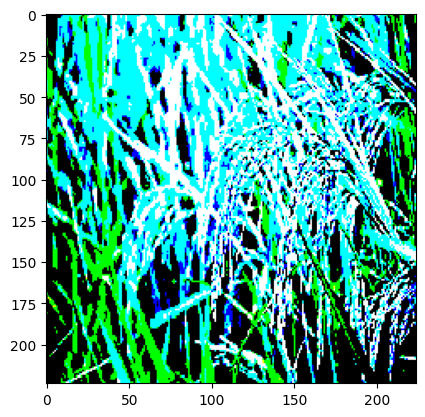

In [25]:
# Get a batch of images and labels
images, labels = next(valid_data)

# Select a random image from the batch
idx = random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.show()

### Load Model ResNet50

In [26]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Building the Model

In [27]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(30, activation='softmax')
])

### Compiling the Model

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Fitting the Model

In [37]:
model.fit(
    train_data, 
    epochs=50, 
    validation_data=valid_data
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4187 - loss: 2.0036 - val_accuracy: 0.5694 - val_loss: 1.5083
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4479 - loss: 1.8178 - val_accuracy: 0.6389 - val_loss: 1.3621
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5061 - loss: 1.6846 - val_accuracy: 0.5833 - val_loss: 1.2589
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5782 - loss: 1.4391 - val_accuracy: 0.6806 - val_loss: 1.1476
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5721 - loss: 1.3473 - val_accuracy: 0.7222 - val_loss: 1.0526
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6150 - loss: 1.3233 - val_accuracy: 0.7361 - val_loss: 1.0552
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6104 - loss: 1.2972 - val_accuracy: 0.7222 - val_loss: 0.9776
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6442 - loss: 1.1454 - val_accuracy: 0.7361 - val_loss:

### Evaluating the Model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7905 - loss: 0.6719
Test Accuracy: 79.05%


### Classes Dictionary
There are 30 classes in the test dataset, so we need a dictionary of the classes. We need this to convert the index of the predicted class back to a human readable name.

In [39]:
class_names = {
    0: 'Cherry',
    1: 'Coffee-plant',
    2: 'Cucumber',
    3: 'Fox_nut(Makhana)',
    4: 'Lemon',
    5: 'Olive-tree',
    6: 'Pearl_millet(bajra)',
    7: 'Tobacco-plant',
    8: 'almond',
    9: 'banana',
    10: 'cardamom',
    11: 'chilli',
    12: 'clove',
    13: 'coconut',
    14: 'cotton',
    15: 'gram',
    16: 'jowar',
    17: 'jute',
    18: 'maize',
    19: 'mustard-oil',
    20: 'papaya',
    21: 'pineapple',
    22: 'rice',
    23: 'soyabean',
    24: 'sugarcane',
    25: 'sunflower',
    26: 'tea',
    27: 'tomato',
    28: 'vigna-radiati(Mung)',
    29: 'wheat'
}

In [ ]:
# function to help make predictions
def predict_img(image, model):
    test_img=cv2.imread(image)                
    test_img=cv2.resize(test_img, (224,224))  
    test_img=np.expand_dims(test_img, axis=0) 
    result=model.predict(test_img)            
    r=np.argmax(result)                        
                                              
    print(class_names[r])

In [ ]:
# test the function
predict_img(
    'output/test/jowar/image (3).jpeg', model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
jowar


In [ ]:
# another test
predict_img(
    'output/test/tomato/image (6).jpeg', model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
tomato


### Saving the Model
This is how `Keras/TensorFlow` models are saved.

In [ ]:
model.save('CropModel.keras')